4. Kernel Density Estimation. There is an array of datapoints saved in datasets/peaking.npy. They have a distribution which looks like it peaks.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from iminuit import Minuit
from iminuit.cost import UnbinnedNLL

In [2]:
# read from npy file
with open('peaking.npy', 'rb') as f:
    data = np.load(f)
    print(data)
print (type(data))

print (len(data))
print (min(data))
print (max(data))
print (np.mean(data))
print (np.std(data))


[0.59361156 4.41745643 3.58323885 ... 4.18286168 9.88500843 3.2386589 ]
<class 'numpy.ndarray'>
10000
-25888.8515412115
14.890909768137263
-0.977369393431856
265.00764982762


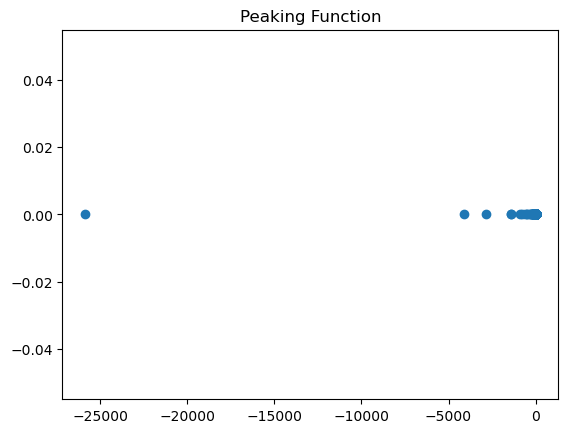

In [3]:
# plot the data using histogram
plt.scatter(data, np.zeros_like(data))
plt.title('Peaking Function')
plt.show()

In [4]:
# Calculate the mean and standard deviation
mean_value = np.mean(data)
std_value = np.std(data)

# Define a threshold value for number of standard deviations
threshold = 10

# Define the lower and upper bounds for outliers
lower_bound = mean_value - threshold * std_value
upper_bound = mean_value + threshold * std_value

# Identify and remove outliers
data = data[(data >= lower_bound) & (data <= upper_bound)]

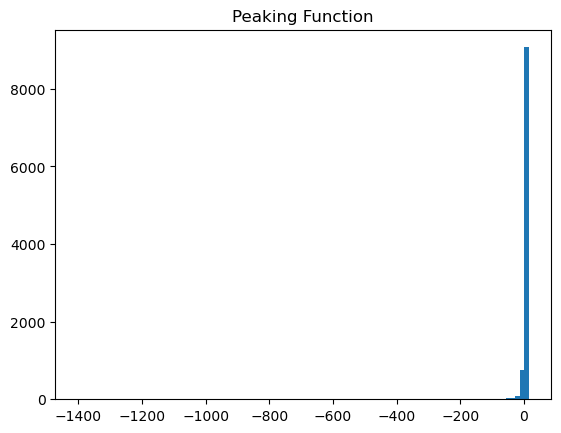

In [5]:
# plot the data using histogram
plt.hist(data, bins=100)
plt.title('Peaking Function')
plt.show()

(a) Try fitting these points with a normal distribution. What do you think of the outcome?


In [6]:
def norm_model(x, _mu:float, _sigma: float) -> float:
    return 1 / (_sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - _mu) / _sigma) ** 2)

In [7]:
# negative log likelihood
nll = UnbinnedNLL(data, norm_model)

# create Minuit object
mi = Minuit(nll, _mu=mean_value, _sigma=std_value)

# run the minimizer
mi.migrad()

mi.hesse()

# print the result
print(mi.values.to_dict())

dict_parameters = mi.values.to_dict()



{'_mu': 2.9097692772487953, '_sigma': 10.180833428457328}


/Users/zhongjunbao/miniconda3/envs/mphil/lib/python3.9/site-packages/iminuit/cost.py:75: RuntimeWarning: invalid value encountered in log
  return np.log(x + 1e-323)


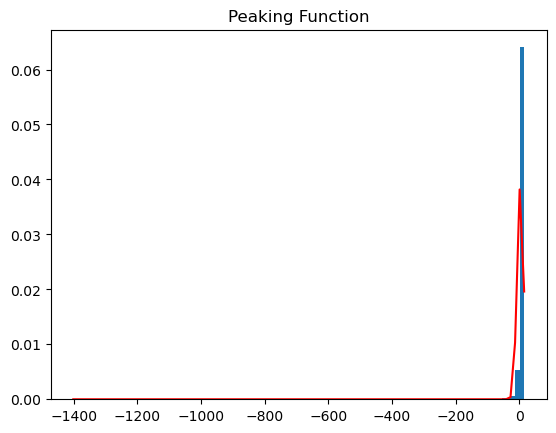

In [8]:
# plot the data using histogram and the fitted function
plt.hist(data, bins=100, density=True)
plt.title('Peaking Function')
x = np.linspace(min(data), max(data), 100)
plt.plot(x, norm_model(x, **dict_parameters), color='red')
plt.show()


(b) Try fitting these points with a sum of two normal distributions. Is it looking any better?

In [9]:
def norm_model_2(x, _mu1, _sigma1, _mu2, _sigma2, _f):
    pdf = _f * norm_model(x, _mu1, _sigma1) + (1-_f) * norm_model(x, _mu2, _sigma2)
    return pdf

In [10]:
# negative log likelihood
nll = UnbinnedNLL(data, norm_model_2)

# create Minuit object
mi = Minuit(nll, _mu1 = mean_value, _mu2 = mean_value, _sigma1=std_value, _sigma2 = std_value, _f = 0.5)

# run the minimizer
mi.migrad()

# run the Hesse algorithm
mi.hesse()

# save the result in a dictionary
dict_parameters = mi.values.to_dict()
print (dict_parameters)



{'_mu1': -0.977369393431856, '_sigma1': 7.356723310287428, '_mu2': -0.977369393431856, '_sigma2': 56.28802551026581, '_f': 0.5}


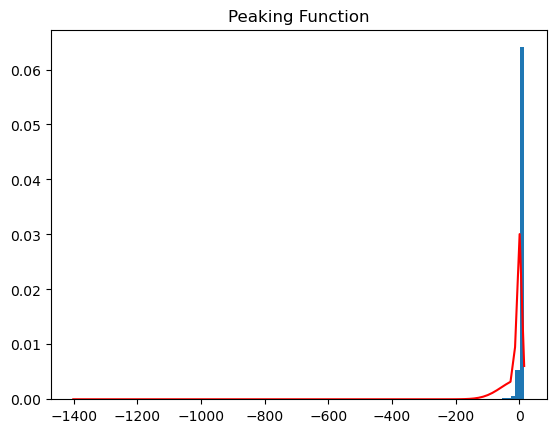

In [11]:
# plot the data using histogram and the fitted function
plt.hist(data, bins=100, density=True)
plt.title('Peaking Function')
x = np.linspace(min(data), max(data), 100)
plt.plot(x, norm_model_2(x, **dict_parameters), color='red')
plt.show()

(c) What about a sum of three? Can you find any empirical distribution which fits ok?

In [12]:
def norm_model_N (x, *args):
    N = len(args)//3
    _mu = args[:N]
    _sigma = args[N:2*N]
    _f = args[2*N:]
    pdf = 0
    for i in range(N):
        pdf += _f[i] * norm_model(x, _mu[i], _sigma[i])
    return pdf/sum(_f)

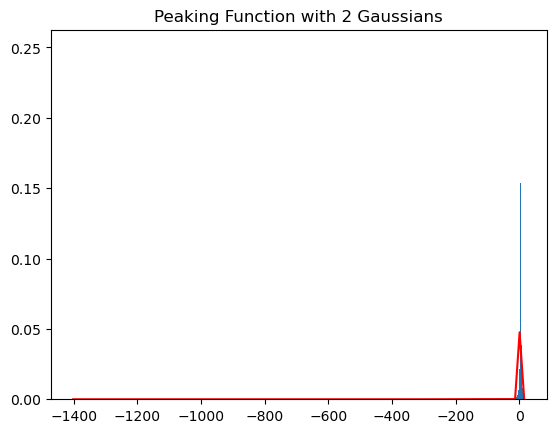

{'_mu1': 4.042371577754351, '_mu2': -38.948753063417556, '_sigma1': 2.116112501427021, '_sigma2': 125.97202486952894, '_f1': 0.00016346597215421976, '_f2': 6.881966061134115e-06}


In [13]:
# try to fit the data with N gaussians

from sklearn.model_selection import ParameterSampler


for N in range (2,3):

    # negative log likelihood
    nll = UnbinnedNLL(data, norm_model_N)

    # initial values for the parameters
    init_mu = [np.mean(data)] * N
    init_sigma = [np.std(data)] * N
    init_f = [1/N] * N
    init_parameters = init_mu + init_sigma + init_f

    # create Minuit object
    mi = Minuit(nll, *init_parameters)

    # set limits for the parameters
    mi.limits = [(None, None)] * N + [(0, None)] * N + [(0, 1)] * N

    # run the minimizer
    mi.migrad()

    # run the Hesse algorithm
    mi.hesse()

    # save the result in a dictionary
    dict_parameters_x = mi.values.to_dict()

    # plot the data using histogram and the fitted function
    plt.hist(data, bins=1000, density=True)
    plt.title('Peaking Function')
    x = np.linspace(min(data), max(data), 100)
    plt.plot(x, norm_model_N(x, *mi.values), color='red')
    plt.title(f'Peaking Function with {N} Gaussians')
    plt.show()
    
    # rename the keys of the dictionary
    dict_parameters = {f'_mu{i+1}': dict_parameters_x[f"x{i}"] for i in range(N)}
    dict_parameters.update({f'_sigma{i+1}': dict_parameters_x[f"x{i+N}"] for i in range(N)})
    dict_parameters.update({f'_f{i+1}': dict_parameters_x[f"x{i+2*N}"] for i in range(N)})
    print (dict_parameters)

(d) Now try using a kernel density estimate with bandwidths of 0.1, 0.2, 0.5, 1 and chosen using the Scott algorithm. Which do you think is best?

In [14]:
from sklearn.neighbors import KernelDensity

In [15]:
band_width_list = [0.1, 0.2, 0.5 ,1, "scott"]

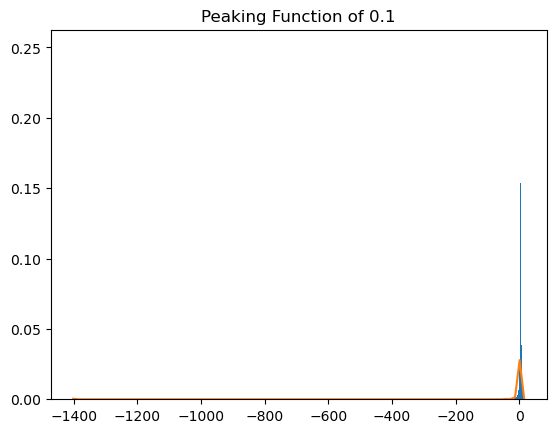

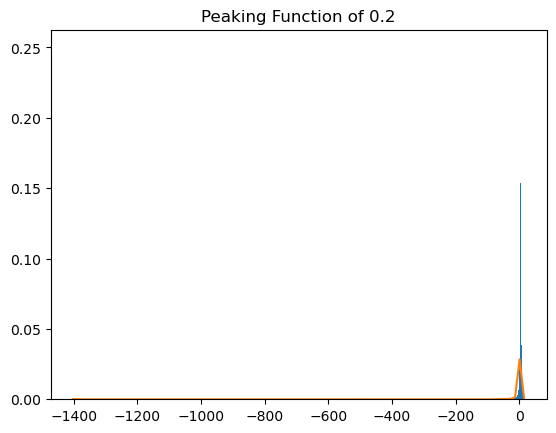

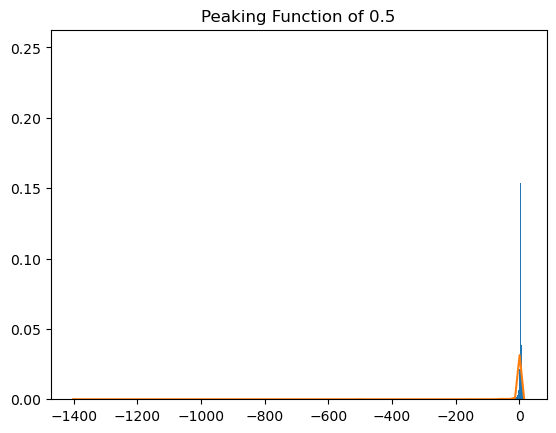

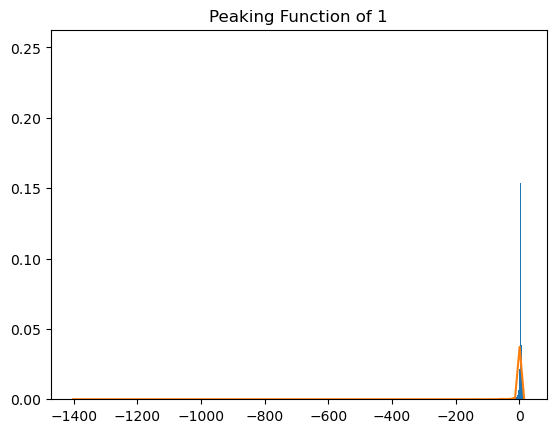

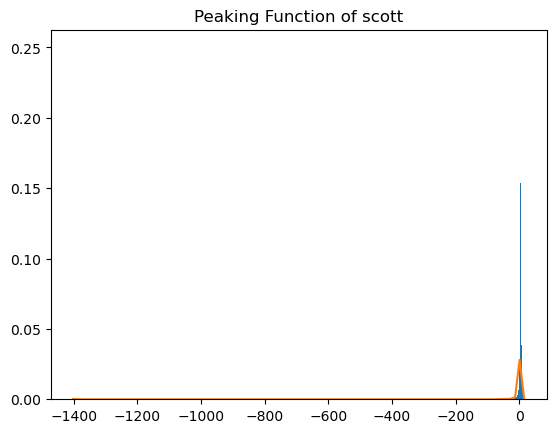

In [16]:
for band_width in band_width_list:
    kde = KernelDensity(kernel='gaussian', bandwidth=band_width).fit(data.reshape(-1, 1))
    x = np.linspace(min(data), max(data), 100)
    log_dens = kde.score_samples(x.reshape(-1, 1))
    plt.hist(data, bins=1000, density=True)
    plt.plot(x, np.exp(log_dens), label=f"bandwidth = {band_width}")
    plt.title (f'Peaking Function of {band_width}')
    plt.show()